<a href="https://colab.research.google.com/github/LeyloJohnny/Computational-Neuroscience/blob/main/HMM_analysis_first_steps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#HMM Analysis

##Imports

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
import scipy.stats as st
import multiprocessing

In [2]:
#get data from google drive
!gdown --id 1qblO7uQCJ6KKclqS-rhvXfQ7ccWcmxaA
#unzip data
!unzip 'NewData.zip'

Downloading...
From: https://drive.google.com/uc?id=1qblO7uQCJ6KKclqS-rhvXfQ7ccWcmxaA
To: /content/NewData.zip
127MB [00:01, 66.0MB/s]
Archive:  NewData.zip
  inflating: Cluster.pkl             
  inflating: BN.pkl                  
  inflating: SFA.pkl                 


In [3]:
!ls

BN.pkl	Cluster.pkl  NewData.zip  sample_data  SFA.pkl


##Access data

In [4]:
#create a list of model name strings
models = ['BN.pkl', "SFA.pkl", "Cluster.pkl"]

#create a list of model names
model_names = ["Balanced Network", "Clustered with SFA", "Clustered wo SFA"]

#create lists to store model data
models_x = []
models_y = []

#for all models
for i in range(len(models)):

  #open pickle file
  with open(models[i], 'rb') as f:
    #get x (actual data: time * neuron id)
    x = pickle.load(f)
    #get y (information on data, such as inhibitory/excitatory neurons, clusters, etc.)
    y = pickle.load(f)
    #add x and y to the models lists
    models_x.append(x)
    models_y.append(y)

##Create raster plot

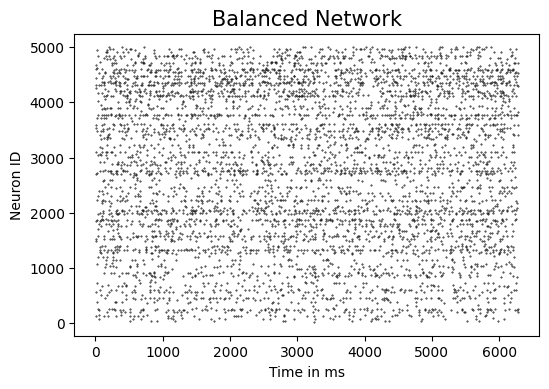

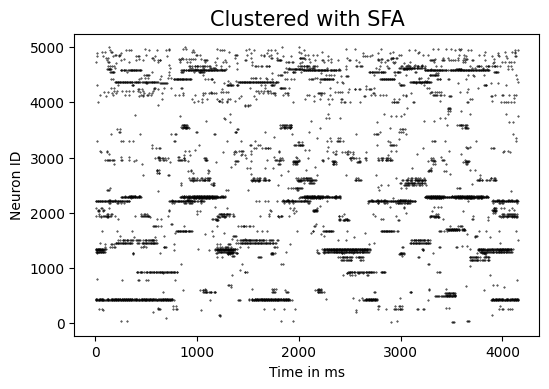

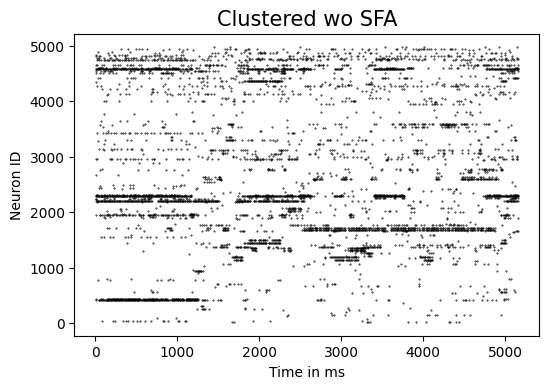

In [5]:
#create list for all three raster plots
rasterplots = []

#for all models
for i in range(len(models)):

  #create figure
  figure = plt.figure(dpi=100)
  #create subplot
  ax = figure.add_subplot(1,1,1)
  #plot both dimensions of x (time, neuron id)
  plt.plot(models_x[i][0][:5000],models_x[i][1][:5000],'.k',markersize = 0.8) 

  #label the plot
  ax.set_xlabel('Time in ms', fontsize = 10)
  ax.set_ylabel('Neuron ID', fontsize = 10)
  ax.set_title(model_names[i], fontsize = 15)

  #store plots in list
  rasterplots.append(figure)


##Create spike count matrix

In [6]:
#define a time window (in milliseconds)
window = 100

#calculate number of intervals based on recorded time span / time window
intervals = int(np.max(models_x[i][0, :]+ 1)/window)

#define which neurons to focus on (here: only excitatory neurons 0 - 4000)
neurons = int(np.max(models_x[i][1, :])+1) - 1000

#how many intervals do we have?
print("We have " + str(intervals) + " intervals, each " + str(window) + "ms long. \n")

spike_count_matrix = np.zeros((len(models), intervals, neurons))

#for every model
for i in range(len(models)):
  #get the data of the current model
  current_model_x = np.array(models_x[i])

  #create a zeros array with size time * neurons (5000*4000)
  spike_counts = np.zeros((intervals, neurons))

  #for every interval
  for j in range(intervals):

    #get the indices of time points within the current interval
    interval_time_points = np.where(np.logical_and(window*j <= current_model_x[0], current_model_x[0] < window*(j+1)))

    #get data indexed by current interval
    interval_data = current_model_x[1][interval_time_points]
    
    #for every neuron
    for k in range(neurons):

        #get the indices of the current neuron within the defined time interval
        current_neuron = np.where(interval_data == k)

        #get the number of spikes based on the amount of neuron indices within the defined time interval
        spikes = current_neuron[0].shape[0]

        #add spikes number to spike count matrix
        spike_counts[j, k] = spikes
  
  #add spike count matrix for every model
  spike_count_matrix[i] = spike_counts

#print data
print("The spike count matrix has the shape: " + str(spike_count_matrix.shape) + " representing " + 
      str(spike_count_matrix.shape[0]) + " models, " + str(spike_count_matrix.shape[1]) + " intervals, and " + str(spike_count_matrix.shape[2]) + " neurons. \n")
print("Spike count matrix: \n")
print(spike_count_matrix)

We have 3000 intervals, each 100ms long. 

The spike count matrix has the shape: (3, 3000, 4000) representing 3 models, 3000 intervals, and 4000 neurons. 

Spike count matrix: 

[[[0. 0. 0. ... 1. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 2. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 1. 0. 0.]
  [0. 0. 0. ... 0. 0. 1.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [2. 2. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [2. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 1. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 1. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [1. 1. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 1. 0.]]]


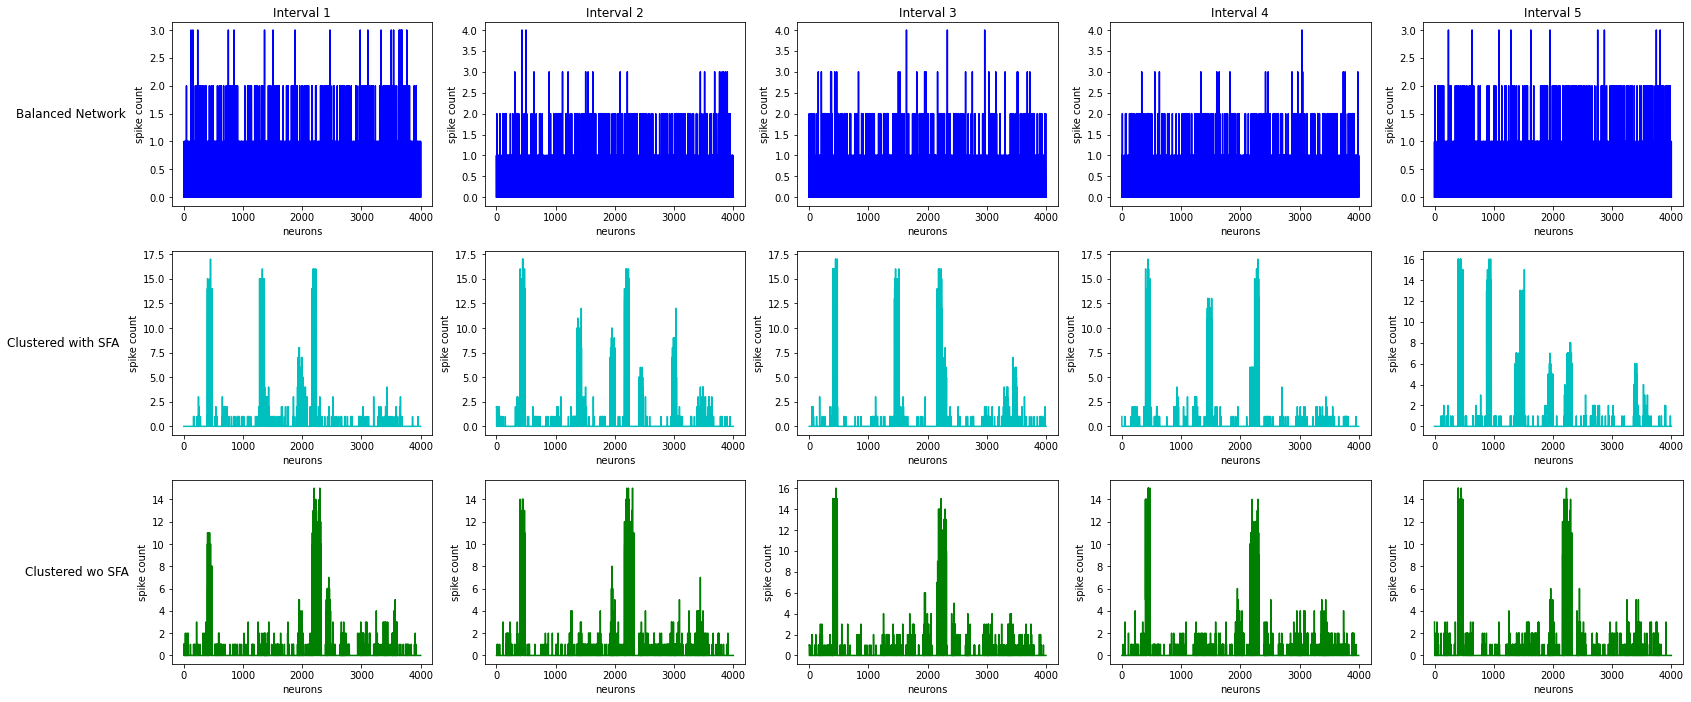

In [7]:
from matplotlib.transforms import offset_copy

if intervals > 5: 
  intervals_to_plot = 5

#initiate figure and axes with specific size, rows = number of models, columns = number of intervals
fig, axes = plt.subplots(figsize= (25, 10), nrows=len(models), ncols=intervals_to_plot)

#define title for columns and rows (intervals and model names)
cols = ['Interval {}'.format(int(col+1)) for col in range(intervals_to_plot)]
rows = ['{}'.format(row) for row in model_names]

#define x and y axes of each subplot (neurons and spike count)
plt.setp(axes.flat, xlabel='neurons', ylabel='spike count')

#define pad (required for spacing between subplots and labels)
pad = 5 # in points

#label columns
for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')
    
#labels rows
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

#arrange subplots 
fig.tight_layout()
# tight_layout doesn't take labels into account 
# more space needed:
fig.subplots_adjust(left = 0.15, top = 0.95)

#define colors for different models
colors = ['b', 'c', 'g']

#for every interval
for interval in range(intervals_to_plot):
  #for every model
  for model in range(len(models)):
    #make subplots, intervals in columns, models in rows, different color for every model
    #y axis: spike count (based on spike count matrix)
    #x axis: neurons (based on max. neuron id)
    axes[model, interval].plot(range(neurons), spike_count_matrix[model][interval], colors[model])

#show the figure
plt.show()

##Generate dataframe

In [8]:
#define titles for columns and rows in the dataframe that will be generated from the spike count matrix
cols = ['Neuron{}'.format(int(col+1)) for col in range(neurons)] #rows represent the neurons (= features)
rows = ['Interval{}'.format(int(row+1)) for row in range(intervals)] #columns represent the time intervals/time bins (= samples)

#create list for the data to be analyzed for each model
models_data = []

#for every model
for i in range(len(models)):
  #create a dataframe from the spike count matrix
  current = spike_count_matrix[i]
  data = pd.DataFrame(data = current, index = rows, columns = cols)
  #add the dataframe to the list (containing one dataframe per model)
  models_data.append(data)

#exemplarily show the dataframe for the second model
models_data[2].head(intervals)

,Neuron1,Neuron2,Neuron3,Neuron4,Neuron5,Neuron6,Neuron7,Neuron8,Neuron9,Neuron10,Neuron11,Neuron12,Neuron13,Neuron14,Neuron15,Neuron16,Neuron17,Neuron18,Neuron19,Neuron20,Neuron21,Neuron22,Neuron23,Neuron24,Neuron25,Neuron26,Neuron27,Neuron28,Neuron29,Neuron30,Neuron31,Neuron32,Neuron33,Neuron34,Neuron35,Neuron36,Neuron37,Neuron38,Neuron39,Neuron40,...,Neuron3961,Neuron3962,Neuron3963,Neuron3964,Neuron3965,Neuron3966,Neuron3967,Neuron3968,Neuron3969,Neuron3970,Neuron3971,Neuron3972,Neuron3973,Neuron3974,Neuron3975,Neuron3976,Neuron3977,Neuron3978,Neuron3979,Neuron3980,Neuron3981,Neuron3982,Neuron3983,Neuron3984,Neuron3985,Neuron3986,Neuron3987,Neuron3988,Neuron3989,Neuron3990,Neuron3991,Neuron3992,Neuron3993,Neuron3994,Neuron3995,Neuron3996,Neuron3997,Neuron3998,Neuron3999,Neuron4000
Interval1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Interval2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Interval3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Interval4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Interval5,3.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Interval2996,2.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Interval2997,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Interval2998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Interval2999,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.

###Delete silent neurons

In [9]:
silent_neurons = []
all_models_silent = []

for model in range(len(models)):
  model_silent_neurons = []
  for neuron in range(neurons):
    if models_data[model].iloc[:, neuron].sum(0) == 0:
      model_silent_neurons.append(neuron+1)
  silent_neurons.append(model_silent_neurons)

In [10]:
len(silent_neurons[0]), len(silent_neurons[1]), len(silent_neurons[2])

(1, 7, 20)

In [11]:
for model in range(len(models)):
  for neuron_number in range(len(silent_neurons[model])):
    neuron = silent_neurons[model][neuron_number]
    del models_data[model]["Neuron" + str(neuron)]

In [12]:
models_data[2].head()

,Neuron1,Neuron2,Neuron3,Neuron4,Neuron5,Neuron6,Neuron7,Neuron8,Neuron9,Neuron10,Neuron11,Neuron12,Neuron13,Neuron14,Neuron15,Neuron16,Neuron17,Neuron18,Neuron19,Neuron20,Neuron21,Neuron22,Neuron23,Neuron24,Neuron25,Neuron26,Neuron27,Neuron28,Neuron29,Neuron30,Neuron31,Neuron32,Neuron33,Neuron34,Neuron35,Neuron36,Neuron38,Neuron39,Neuron40,Neuron41,...,Neuron3961,Neuron3962,Neuron3963,Neuron3964,Neuron3965,Neuron3966,Neuron3967,Neuron3968,Neuron3969,Neuron3970,Neuron3971,Neuron3972,Neuron3973,Neuron3974,Neuron3975,Neuron3976,Neuron3977,Neuron3978,Neuron3979,Neuron3980,Neuron3981,Neuron3982,Neuron3983,Neuron3984,Neuron3985,Neuron3986,Neuron3987,Neuron3988,Neuron3989,Neuron3990,Neuron3991,Neuron3992,Neuron3993,Neuron3994,Neuron3995,Neuron3996,Neuron3997,Neuron3998,Neuron3999,Neuron4000
Interval1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Interval2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Interval3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Interval4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Interval5,3.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
clone_models_data = models_data

In [14]:
min_neurons = np.min([clone_models_data[0].shape[1], clone_models_data[1].shape[1], clone_models_data[2].shape[1]])

In [15]:
shortened_data = []

for model in range(len(models)):
  keep_sample = clone_models_data[model].sample(min_neurons, axis = 'columns')
  shortened_data.append(keep_sample)

In [16]:
shortened_data[2].head(intervals)

,Neuron2965,Neuron1161,Neuron917,Neuron3520,Neuron1285,Neuron1412,Neuron3693,Neuron3066,Neuron66,Neuron91,Neuron1206,Neuron828,Neuron1540,Neuron948,Neuron3924,Neuron695,Neuron1998,Neuron1907,Neuron104,Neuron3760,Neuron1979,Neuron3074,Neuron2053,Neuron3227,Neuron778,Neuron1879,Neuron3570,Neuron1475,Neuron3135,Neuron3100,Neuron2934,Neuron1510,Neuron2073,Neuron7,Neuron577,Neuron238,Neuron1392,Neuron2006,Neuron3725,Neuron110,...,Neuron1252,Neuron1377,Neuron94,Neuron1767,Neuron2266,Neuron793,Neuron2160,Neuron2821,Neuron2136,Neuron3782,Neuron1478,Neuron3400,Neuron1458,Neuron1343,Neuron1869,Neuron2180,Neuron3306,Neuron1407,Neuron2023,Neuron1393,Neuron1807,Neuron2908,Neuron3885,Neuron297,Neuron3034,Neuron397,Neuron2125,Neuron1574,Neuron356,Neuron950,Neuron2533,Neuron198,Neuron3130,Neuron3751,Neuron1986,Neuron871,Neuron2221,Neuron1813,Neuron2695,Neuron3650
Interval1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Interval2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Interval3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Interval4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Interval5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Interval2996,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
Interval2997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Interval2998,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Interval2999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

#HMM

In [17]:
!pip install git+git://github.com/lindermanlab/ssm
import ssm

  Cloning git://github.com/lindermanlab/ssm to /tmp/pip-req-build-n8i1akg4
  Running command git clone -q git://github.com/lindermanlab/ssm /tmp/pip-req-build-n8i1akg4
  Created wheel for ssm: filename=ssm-0.0.1-cp37-cp37m-linux_x86_64.whl size=399513 sha256=12661e386ab29dca3d09e5d8735bb287ac3bca5a30a47370e83ded892559b648
  Stored in directory: /tmp/pip-ephem-wheel-cache-euyrg581/wheels/82/71/55/886c7f4ed86fbde1aa2f4e598d010b6d9a761be84320ac95ec
Successfully built ssm


In [18]:
data = shortened_data

data_list = []
network_type = []

#short version
n_neurons = 112
obs_dim = n_neurons

parts = 40

part_length = int(data[1].shape[0]/parts)
time_bins = part_length
print(part_length)

models_subsamples = []

#for all models
for model in range(len(models)):
  #create list for subsamples
  test = data[model]
  current_part_data = []
  models_parts = []
  for part in range(parts): 
    part_start = part*part_length 
    part_end = (part+1)*part_length
    current_part = data[model][part_start:part_end]
    current_part_data.append(current_part)

    sample = current_part.sample(int(n_neurons), axis = 'columns')

    for neuron in range(sample.shape[1]):
      del current_part_data[part][list(sample)[neuron]]
    
    models_parts.append(sample.to_numpy())

    data_list.append(sample.to_numpy())
    network_type.append(model_names[model])


  models_subsamples.append(models_parts)


75


In [19]:
len(models_subsamples[0])

40

In [52]:
synthetic_data = shortened_data[1]

In [53]:
synthetic_data

,Neuron746,Neuron340,Neuron289,Neuron2487,Neuron469,Neuron1758,Neuron3460,Neuron2901,Neuron3062,Neuron2190,Neuron403,Neuron1105,Neuron2886,Neuron305,Neuron213,Neuron2990,Neuron3188,Neuron3503,Neuron518,Neuron2209,Neuron1957,Neuron1760,Neuron1617,Neuron7,Neuron3561,Neuron1497,Neuron2972,Neuron3896,Neuron2196,Neuron3217,Neuron1974,Neuron2939,Neuron198,Neuron539,Neuron2381,Neuron3074,Neuron1134,Neuron1710,Neuron742,Neuron968,...,Neuron1909,Neuron470,Neuron3513,Neuron3445,Neuron2078,Neuron151,Neuron2819,Neuron1164,Neuron351,Neuron2556,Neuron144,Neuron732,Neuron670,Neuron3588,Neuron807,Neuron2237,Neuron3700,Neuron1041,Neuron3939,Neuron3540,Neuron1069,Neuron3032,Neuron67,Neuron1108,Neuron1955,Neuron423,Neuron2104,Neuron41,Neuron2328,Neuron660,Neuron1315,Neuron2621,Neuron2539,Neuron2595,Neuron1169,Neuron2989,Neuron3537,Neuron1728,Neuron1717,Neuron2097
Interval1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Interval2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,13.0,6.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0
Interval3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,6.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
Interval4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Interval5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,13.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Interval2996,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Interval2997,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,1.0,0.0,0.0,...,0.0,7.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,3.0,0.0,0.0,0.0,0.0
Interval2998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,2.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0
Interval2999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [54]:
synthetic_data = shortened_data[1]

N_iters = 50
num_states = 10    # number of discrete states
obs_dim = 3980       # dimensionality of observation

##===== Create HMM object to fit =====## 
hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")

#This beautiful line of code hides all the business of fitting Hidden Markov models to data under the hood.
#Go look at the source code and marvel at how code should be written. 
hmm_lls = hmm.fit(synthetic_data, method="em", num_iters=N_iters, init_method="kmeans")

#Plot log-likelihood over iterations compared to the baseline log-likelihood we calculated earlier
plt.plot(hmm_lls, label="EM")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

TypeError: ignored

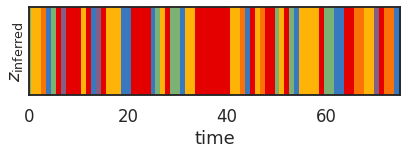

In [55]:
import seaborn as sns
sns.set_style("white")
sns.set_context("talk")
import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

# Plot the inferred discrete states
hmm_z = hmm.most_likely_states(synthetic_data)

plt.subplot(212)
plt.imshow(hmm_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, time_bins)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

In [20]:
##===== Create function so we can parallelize =====##
def fit_ssm_get_llhood(training_data,test_data, num_states):
    N_iters = 5
    nT, nNeurons = training_data[0].shape
    
    #Number of parameters for the model: (initial state distribution) + (transition matrix) + (mean values for each state) 
    num_parameters = num_states + num_states*num_states + num_states*nNeurons
    
    #Create HMM object to fit
    hmm = ssm.HMM(num_states, nNeurons, observations="gaussian")

    #fit on training data
    hmm_lls = hmm.fit(training_data, method="em", num_iters=N_iters)#, init_method="kmeans")

    #Count total number of time steps in data
    nTrain = sum(map(len, training_data))
    nTest = sum(map(len, test_data))
    
    #Compute log-likelihood for each dataset
    ll_training = hmm.log_probability(training_data)/nTrain
    ll_heldout = hmm.log_probability(test_data)/nTest

    #Let's calculate the BIC as well for this
    BIC_heldout = num_parameters*np.log(nTest) - 2*hmm.log_probability(test_data)
    
    return ll_training, ll_heldout, BIC_heldout

In [ ]:
from sklearn.model_selection import KFold

##===== K-fold Cross-Validation =====##

#Create kfold cross-validation object which will split data for us
nKfold = 5

data_list = models_subsamples[1]

#So 10-fold stratified cross-validation uses 90% of the data to train the model, and holds 10% for testing,
#ensuring equal proportions of data in the train and test sets of all the groups you want to stratify over

#kf = StratifiedKFold(n_splits=nKfold, shuffle=True, random_state=None)   
kf = KFold(n_splits=5, shuffle=True, random_state=1) 

#11 different nnumber of latent states
#10-fold cross-validation
#That's 110 model fits! Thankfully this can be parallelized fairly easily
Ks = np.arange(1,10,1)

ll_training = np.zeros((len(Ks),nKfold))
ll_heldout = np.zeros((len(Ks),nKfold))
BIC_heldout = np.zeros((len(Ks),nKfold))

# Creates parallel processes
pool = multiprocessing.Pool(processes=55)
    
process_outputs = []
#Outer loop over the parameter for which you're doing model selection for
for iS, num_states in enumerate(Ks):

    kfold_outputs = []
    #Inner loop over kfolds
    #for ii, (train_index, test_index) in enumerate(kf.split(data_list, network_type)):   
    for train_index, test_index in kf.split(data_list):    
        #Split data
        training_data = [data_list[ii] for ii in train_index]
        test_data = [data_list[ii] for ii in test_index]
        
        #Parallize process
        kfold_outputs.append(pool.apply_async(fit_ssm_get_llhood, args=(training_data, test_data, num_states)))
    process_outputs.append(kfold_outputs)

#Extract log_likelihood results from parallel kfold processing
for index, results in enumerate(process_outputs):
    print(index)
    print(results)
    ll_training[index,:] = np.array([iFold.get()[0] for iFold in results])
    ll_heldout[index,:] = np.array([iFold.get()[1] for iFold in results])
    BIC_heldout[index,:] = np.array([iFold.get()[2] for iFold in results])
  

0
[<multiprocessing.pool.ApplyResult object at 0x7ff57b3f1d90>, <multiprocessing.pool.ApplyResult object at 0x7ff57b3c5410>, <multiprocessing.pool.ApplyResult object at 0x7ff57b3c5510>, <multiprocessing.pool.ApplyResult object at 0x7ff57b3c5610>, <multiprocessing.pool.ApplyResult object at 0x7ff57b3c5710>]





1
[<multiprocessing.pool.ApplyResult object at 0x7ff57b3c58d0>, <multiprocessing.pool.ApplyResult object at 0x7ff57b3c5a90>, <multiprocessing.pool.ApplyResult object at 0x7ff57b3c5c50>, <multiprocessing.pool.ApplyResult object at 0x7ff57b3c5d50>, <multiprocessing.pool.ApplyResult object at 0x7ff57b3c5e10>]





2
[<multiprocessing.pool.ApplyResult object at 0x7ff57b3c5f90>, <multiprocessing.pool.ApplyResult object at 0x7ff57b3cc090>, <multiprocessing.pool.ApplyResult object at 0x7ff57b3cc190>, <multiprocessing.pool.ApplyResult object at 0x7ff57b3cc290>, <multiprocessing.pool.ApplyResult object at 0x7ff57b3cc390>]





3
[<multiprocessing.pool.ApplyResult object at 0x7ff57b3cc510

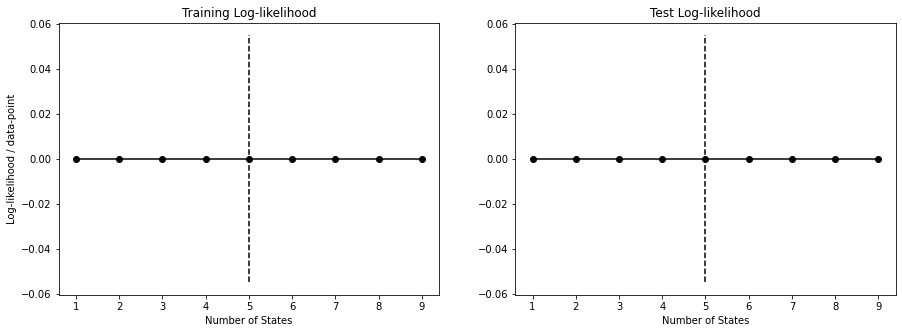

In [ ]:
#Plot the log-likelihood of the training and test datasets

fig, axes = plt.subplots(1,2,figsize=(15,5),sharey=False)

#Training data
axes[0].plot(np.arange(1,11),ll_training,'.')
axes[0].plot(np.arange(1,11),np.mean(ll_training,axis=1),'-ok')
axes[0].set_title('Training Log-likelihood')
axes[0].set_ylabel('Log-likelihood / data-point')

axes[1].plot(np.arange(1,11),ll_heldout,'.')
axes[1].plot(np.arange(1,11),np.mean(ll_heldout,axis=1),'-ok')
axes[1].set_title('Test Log-likelihood')

for ax in axes:
    ax.set_xticks(np.arange(1,11))
    ax.set_xlabel('Number of States')
    ax.vlines(5,*ax.get_ylim(),ls='--',color='k')

In [ ]:
'''
from sklearn.model_selection import KFold

synthetic_data = models_subsamples[1]

#Create kfold cross-validation object which will split data for us
nKfold = 5
kf = KFold(n_splits=nKfold, shuffle=True, random_state=None)

#Just for sanity's sake, let's check how it splits the data
#So 5-fold cross-validation uses 80% of the data to train the model, and holds 20% for testing
for ii, (train_index, test_index) in enumerate(kf.split(synthetic_data)):
    print(f"kfold {ii} TRAIN:", len(train_index), "TEST:", len(test_index))
      
#10 different nnumber of latent states
#5-fold cross-validation
#That's 50 model fits! Thankfully this can be parallelized fairly easily
max_states = 10
N_iters = 5
ll_training = np.zeros((max_states,nKfold))
ll_heldout = np.zeros((max_states,nKfold))
BIC_heldout = np.zeros((max_states,nKfold))

hmm_z_ms = np.zeros((max_states,time_bins))
#Outer loop over the parameter for which you're doing model selection for
for iS, num_states in enumerate(range(1,max_states+1)):
    #Number of parameters for the model: (transition matrix) + (mean values for each state) + (covariance matrix for each state)
    K = num_states*num_states + num_states*obs_dim + num_states*obs_dim
      
    #Inner loop over kfolds
    for iK, (train_index, test_index) in enumerate(kf.split(synthetic_data)):
        nTrain = len(train_index); nTest = len(test_index)#*obs_dim
          
        #Split data
        training_data = synthetic_data[train_index]
        test_data = synthetic_data[test_index]
          
        #Create HMM object to fit
        hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")

        #fit on training data
        hmm_lls = hmm.fit(training_data, method="em", num_iters=N_iters)#, init_method="kmeans")
          
        #Compute log-likelihood for each dataset
        ll_training[iS,iK] = hmm.log_probability(training_data)/nTrain
        ll_heldout[iS,iK] = hmm.log_probability(test_data)/nTest
          
        #Let's calculate the BIC as well for this
        BIC_heldout[iS,iK] = K*np.log(nTest) - 2*hmm.log_probability(test_data)
          
    #Let's do a full model fit and get the state-sequence
    hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")
    hmm_lls = hmm.fit(synthetic_data, method="em", num_iters=N_iters)
    most_likely_states = hmm.most_likely_states(synthetic_data)
      
    hmm_z_ms[iS,:] = hmm.most_likely_states(synthetic_data)

'''


In [ ]:
'''

from sklearn.model_selection import KFold

synthetic_data = models_subsamples[1]

subsamples = len(synthetic_data)
    
#10 different number of latent states
#5-fold cross-validation
#That's 50 model fits! Thankfully this can be parallelized fairly easily
max_states = 10
N_iters = 5
ll_training = np.zeros((max_states,subsamples))
ll_heldout = np.zeros((max_states,subsamples))

train_index = np.arange(0, int(0.8 * synthetic_data[1].shape[0]), 1)
test_index = np.arange(int(0.8 * synthetic_data[1].shape[0]), int(synthetic_data[1].shape[0]), 1)

hmm_z_ms = np.zeros((max_states,time_bins))

#Outer loop over the parameter for which you're doing model selection for
for iS, num_states in enumerate(range(1,max_states+1)):

    #Inner loop over kfolds
    for iK in range(subsamples):

        nTrain = len(train_index); nTest = len(test_index)#*obs_dim
          
        #Split data
        training_data = synthetic_data[iK][train_index]
        test_data = synthetic_data[iK][test_index]
          
        #Create HMM object to fit
        hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")

        #fit on training data
        hmm_lls = hmm.fit(training_data, method="em", num_iters=N_iters)#, init_method="kmeans")
          
        #Compute log-likelihood for each dataset
        ll_training[iS,iK] = hmm.log_probability(training_data)/nTrain
        ll_heldout[iS,iK] = hmm.log_probability(test_data)/nTest

'''